# Portfolio 1

## Setup

In [1]:
# Run this cell if you are using Google Colab
%%capture
! pip install arviz==0.11.00
! pip install pymc3==3.11.1

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from math import pi, sqrt, exp
from pymc3 import math
from scipy import stats

sns.set_context('talk')

In the following exercises, we are going to analyse response time data  from a recent paper [(Legrand et al., 2021)](https://www.biorxiv.org/content/10.1101/2021.02.18.431871v1) using PyMC3.

In [3]:
# Load data frame
df_raw = pd.read_csv('https://github.com/embodied-computation-group/CardioceptionPaper/raw/main/data/Del2_merged.txt')

## Exercise 1 - Preprocessing

This data frame contains behavioral results from a lot of participants, doing a lot of different tasks. The data of interest for us are stored in the `ConfidenceRT` column. This is the time the participant takes to rate a confidence rating scale. Before we go to the analysis part, we should filter this data frame a bit.

* Here we only want to analyze the modality labeled as `Intero`, and drop the other one. 
* We only want to keep the `Subject` and the `ConfidenceRT` columns. 
* Sometimes, no responses were made by the participant, so the column potentially contains NaN values that should be removed. 
* Because we are just testing new models here, we only want to analyze a sub-sample of the data to save time and memory, so we are going to analyze subjects whose ID ends with a `7` and drop the rest of the participants.

You should end up with a data frame containing 2 columns, 1158 rows, and the response time data from 20 participants in total. If you have difficulties doing this filtering process, you can just skip this question and use the entire `ConfidenceRT` column for the next questions.

In [4]:
df = df_raw[(df_raw["Modality"] == "Intero") &  df_raw["Subject"].str.endswith("7") & df_raw["ConfidenceRT"].notna()]
df = df[["Subject", "ConfidenceRT"]]

## Exercise 2 - Gaussian model

There are many ways to describe response time distribution. The most intuitive and simple model would be to use a normal distribution and use the mean and precision of this distribution as parameters of interest for each subject.

We know from the experimental design that the response time cannot be less than 0 seconds or more than 5 seconds. Our first guess will be to use a normal distribution with a mean $\mu$ and a standard deviation $\sigma$. The mean might come from another normal distribution centered at 2.5. We don't want it to be too informative so the standard deviation will be set at 10. The standard deviation might come from a HalfCauchy distribution with a beta parameter set to `2`.

* Use PyMC3 to fit this model to the responses from the first participant only (`sub_0027`) and create one plot using Arviz to synthesize your results.
* Why did you choose this plot?
* Describe what is represented in your plot
* What information should we check if we want to make sure that the MCMC chain from this model can be trusted?

In [5]:
with pm.Model() as gaussian:
  mu = pm.Normal("mu", mu=2.5, sigma=10)
  sigma = pm.HalfCauchy("sigma", beta = 2)
  data = df[df["Subject"] == "sub_0027"]["ConfidenceRT"].to_numpy()

  y = pm.Normal("y", mu=mu, sigma = sigma, observed = data)
  n_trace = pm.sample(2000, tune = 2000)

n_summary = az.summary(n_trace)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


We use the following plot as it gives a good overview of the results, as well as some visual assurance of convergence.

On the left side, we see plots of each parameter posterior distribution, with the mean highlighted, as well as a rugplot of the sampled values. 
On the right side, we can see a trace: as said, this provides a visual assurance of convergence in that, the less patterns and extreme values are present, the better the more uniformly the sampling proceded.

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


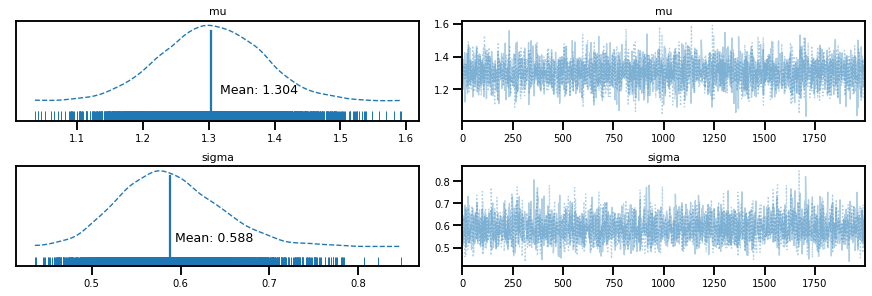

In [6]:
plts = az.plot_trace(n_trace, rug = True, combined = True, show = False)
for i in range(len(n_summary)):
  mean = n_summary['mean'][i]
  plts[i][0].axvline(mean, 0, .9)
  plts[i][0].annotate("Mean: "+str(mean), (mean*1.01, 0.5), fontsize = 'x-small')

In order to "trust" the chain from the model, we need to inspect the R-hat statistic, which is an index of the convergence. It is calculated as the division between two other statistics: the closer these are (and the closer R-hat is to 1) the less evidence for non-convergence there is.

As we see below, these chains can be trusted.

In [7]:
n_summary['r_hat']

mu       1.0
sigma    1.0
Name: r_hat, dtype: float64

## Exercise 3 - Precision

You want to compare your results with another model from the literature that describes the normal distribution using precision ($\lambda$), and not the standard deviation ($\sigma$). We know that: $$\sigma = \frac{1}{\sqrt{\lambda}}$$

* Use `az. summary` to extract the $\sigma$ value from the previous model, and convert it into a precision ($\lambda$) value.

In [ ]:
print(1/(n_summary['mean']['sigma'])**2)
# This should constitute an estimate, as rerunning the model with tau instead 
# of sigma (see below) estimates precision at around 2.95

2.8923133879402108


In [ ]:
with pm.Model() as gaussian2:
  mu = pm.Normal("mu", mu=2.5, sigma=10)
  tau = pm.HalfCauchy("tau", beta = 2)
  data = df[df["Subject"] == "sub_0027"]["ConfidenceRT"].to_numpy()

  y = pm.Normal("y", mu=mu, tau = tau, observed = data)
  n_trace2 = pm.sample(2000, tune = 2000)

az.summary(n_trace2)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [tau, mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,1.306,0.078,1.156,1.451,0.001,0.001,3548.0,3510.0,3571.0,2704.0,1.0
tau,2.974,0.543,1.956,3.951,0.009,0.007,3506.0,3445.0,3509.0,2566.0,1.0


## Exercise 4 - posterior predictive checks

It turns out that this gaussian model is a terrible one for many reasons. We can explore this a bit more by checking the posterior predictive.

* Extract the posterior predictive for this model using the default parameters from PyMC3.
* Plot posterior predictive checks using built-in Arviz function.
* What does this plot tells us? 
* What are the 2 main disadvantages here for response time data?

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


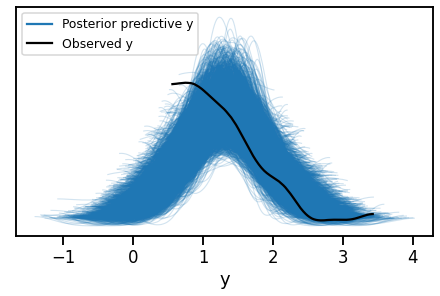

In [ ]:
n_postpred = pm.sample_posterior_predictive(n_trace, model = gaussian)
ppc_data = az.from_pymc3(
    trace = n_trace, posterior_predictive= n_postpred, model = gaussian)
az.plot_ppc(ppc_data, mean = False)

The thickness of the posterior predictive, and its being skewed towards the left with respect to the most occurring datapoints, suggest that the model doesn't fit the data correctly. In particular:
- Response times should not go below a theoretical minimum. Ideally, this minimum is the minimum time possible for a participant to process a stimulus, but more naively and more to the point, they simply cannot be negative. The current model doesn't take this into account.
- What appear to be outlier datapoints (on the right "tail" of the observed curve) seem to skew the posterior towards the left, with the effect of widening the variance (i.e. a very thick posterior prediction).



## Exercise 5 - A better model

The normal distribution is indeed a poor fit for response time data. Other sources suggest that the Gamma distribution or the shifted Wald distribution might do a better job (see [this paper](https://www.frontiersin.org/articles/10.3389/fpsyg.2019.00102/full)). You can find all these distributions already implemented in PyMC3.

Using the same data from subject 27, fit, plot, and summarize the following models separately.

* The gamma model

$$ y \sim \mathcal{Gamma}(alpha=\alpha, beta=\beta)$$
$$ \alpha \sim \mathcal{Uniform}(0, 10)$$
$$ \beta \sim  \mathcal{Uniform}(0, 10)$$

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.7054260553966695, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


        mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
alpha  6.226  1.068   4.291    8.190  ...   544.0     597.0     587.0   1.01
beta   4.778  0.848   3.215    6.346  ...   562.0     598.0     632.0   1.01

[2 rows x 11 columns]


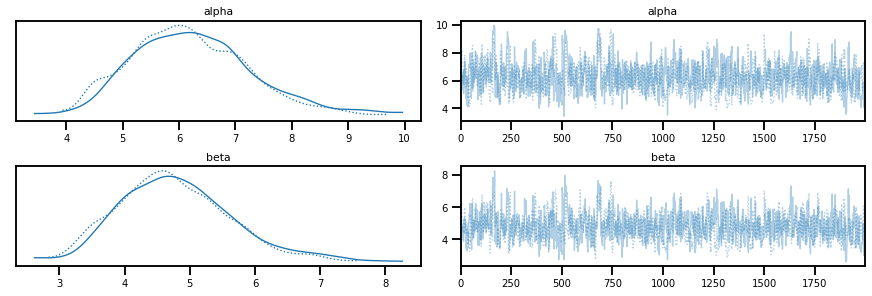

In [8]:
with pm.Model() as gamma:
  alpha = pm.Uniform("alpha", lower=0, upper=10)
  beta = pm.Uniform("beta", lower=0, upper=10)
  data = df[df["Subject"] == "sub_0027"]["ConfidenceRT"].to_numpy()

  y = pm.Gamma("y", alpha = alpha, beta = beta, observed = data)
  g_trace = pm.sample(2000, tune = 2000)

az.plot_trace(g_trace)
g_summary = az.summary(g_trace)
print(g_summary)

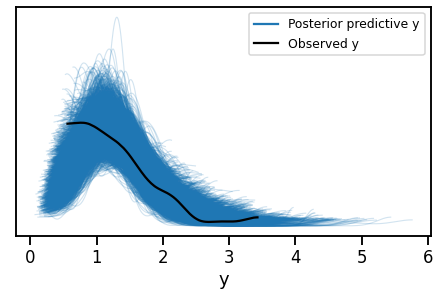

In [ ]:
g_postpred = pm.sample_posterior_predictive(g_trace, model = gamma)
gppc_data = az.from_pymc3(
    trace = g_trace, posterior_predictive= g_postpred, model = gamma)
az.plot_ppc(gppc_data, mean = False)


* The Wald model

$$ y \sim \mathcal{Wald}(\mu, \lambda)$$
$$ \mu \sim \mathcal{Uniform}(0, 5)$$
$$ \lambda \sim  \mathcal{Uniform}(0, 20)$$

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


      mean     sd  hdi_3%  hdi_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
mu   1.317  0.074   1.194    1.469  ...  3093.0    3306.0    2251.0    1.0
lam  7.257  1.306   4.861    9.670  ...  2436.0    2736.0    2311.0    1.0

[2 rows x 11 columns]


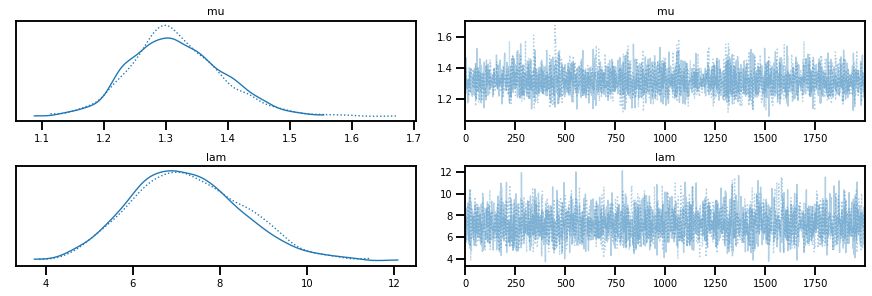

In [9]:
with pm.Model() as wald:
  mu = pm.Uniform("mu", lower=0, upper=5)
  lam = pm.Uniform("lam", lower=0, upper=20)
  data = df[df["Subject"] == "sub_0027"]["ConfidenceRT"].to_numpy()

  y = pm.Wald("y", mu=mu, lam = lam, observed = data)
  w_trace = pm.sample(2000, tune = 2000)

az.plot_trace(w_trace)
w_summary = az.summary(w_trace)
print(w_summary)

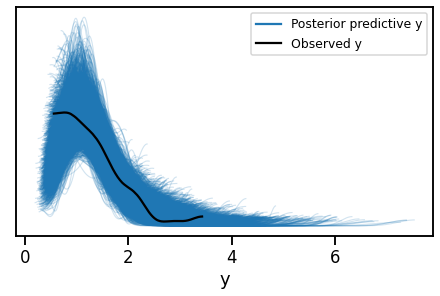

In [ ]:
w_postpred = pm.sample_posterior_predictive(w_trace, model = wald)
wppc_data = az.from_pymc3(
    trace = w_trace, posterior_predictive= w_postpred, model = wald)
az.plot_ppc(wppc_data, mean = False)

## Exercise 6 - Plotting model results


Using the parameters estimates from the previous models, Matplotlib, Seaborn, and the `scipy.stats`module, try to reproduce the following plot
![title](https://github.com/LegrandNico/CognitiveModeling/raw/master/notebooks/data/wald_gamma.png)
:

**Hint**: You can use the gamma function from Scipy to estimate the probability density function, but you will have to create your own Wald function to make it work with the parameters `mu` and `lam` estimated by PyMC3 (see the formula [here](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)).

In [ ]:
def fwald(xi, wmu, wlam):
  term1 = sqrt(wlam/(pi*(xi**3)*2))
  term2 = -(wlam*(xi-wmu)**2)/(2*(wmu**2)*xi)
  return term1*exp(term2)

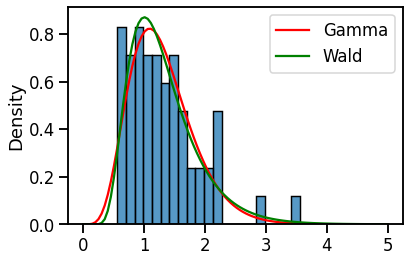

In [ ]:
x = np.linspace(0.001,5, 100)

g_alpha = g_summary['mean']['alpha']
g_beta = g_summary['mean']['beta']
gamma_pdf = stats.gamma.pdf(x, a = g_alpha, scale = 1/g_beta)

w_mu = w_summary['mean']['mu']
w_lam = w_summary['mean']['lam']
wald_pdf = np.array([fwald(xi, w_mu, w_lam) for xi in x])

sns.histplot(data, stat = "density", binwidth=1/7)
sns.lineplot(x = x, y = gamma_pdf, color = "red", label = "Gamma", legend = True)
sns.lineplot(x = x, y = wald_pdf, color = "green", label = "Wald", legend = True)

## Exercise 6 - Model comparison

Compare the previous models (normal distribution, Gamma, Wald). Which one should we choose? What are the metrics/indexes you use to make your decision?

In [10]:
print(az.waic(n_trace))
print(az.waic(g_trace))
print(az.waic(w_trace))

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 4000 by 59 log-likelihood matrix

          Estimate       SE
elpd_waic   -53.40     8.41
p_waic        2.99        -

There has been a warning during the calculation. Please check the results.


/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Computed from 4000 by 59 log-likelihood matrix

          Estimate       SE
elpd_waic   -45.50     6.87
p_waic        2.03        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 by 59 log-likelihood matrix

          Estimate       SE
elpd_waic   -43.67     6.21
p_waic        1.75        -


/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:147: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/arviz/stats/stats.py:1468: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarni

          rank       waic    p_waic  ...       dse  warning  waic_scale
wald         0 -43.666087  1.747633  ...  0.000000    False         log
gamma        1 -45.502342  2.027134  ...  1.253933     True         log
gaussian     2 -53.401155  2.990792  ...  3.930536     True         log

[3 rows x 9 columns]


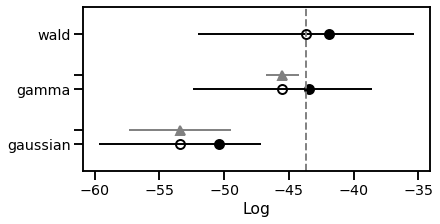

In [11]:
comp = az.compare({'gaussian':n_trace, 'gamma':g_trace, 'wald':w_trace}, method='BB-pseudo-BMA', ic='waic')
print(comp)
az.plot_compare(comp)

Given that the models should have roughly the same level of complexity (if not so, the scores would penalise a higher complexity), the waic scores show us how well the models fit the data: in this sense, a score closer to 0 is preferred.
We can easily see then, that the preferred model should be the wald.

## Exercise 7 - Decision

Imagine the following (completely fictitious) situation: Previous researches have shown that the $\mu$ parameter estimated from the Wald distribution is associated with the anxiety level of the participant. The lower this parameter is, the faster the participant is at confidence rating, and the greater the anxiety level is. If $\mu$ is below 1.2, the anxiety level is considered clinically relevant and the participant should be oriented to a specialist.

You want to make a decision concerning subject 27, and you want to make it probabilistically (i.e. you want to take the decision, but also estimate how sure you are about this decision).

* Given your estimation of $\mu$ from the previous model, do you consider this score to be clinically relevant here?
* What is the probability that $\mu$ is actually below 1.2 for this participant?

Arviz allows us to plot the distribution of a parameter as a cumulative distribution function, for which, at a given point x, it gives the probability that the parameter is less than or equal to x.

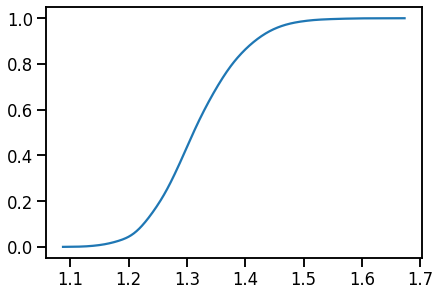

In [31]:
cdf = az.plot_dist(w_trace['mu'], cumulative=True)

In [50]:
pmu = [ dat for dat in cdf.lines[0].get_xydata() if dat[0] > 1.1999 and dat[0] < 1.202 ][0][1]
print(pmu)

0.04575173143798995


We can easily see then, that the probability of $\mu$ being less than 1.2 is around 4.5%, so not to worry too much, but keep an eye (better safe than sorry).

## Exercise 8 - Hierarchical model

Using the entire dataset this time (20 subjects), we are going to fit a hierarchical Wald model. Instead of fixing the prior of the parameters of the Wald function, we want to sample them from hyperpriors (i.e each participant will have its own $\mu$ and $\lambda$ parameters coming from a unique normal distributionm and we want to estimate the mean and standard deviation of these distributions). The hierarchical model for $i = 20$ participants is defined by:

$$ y_{i} \sim \mathcal{Wald}(\mu_{i}, \lambda_{i})$$
$$ \mu_{i} \sim \mathcal{N}(\mu_{\mu}, \sigma_{\mu})$$
$$ \lambda_{i} \sim  \mathcal{N}(\mu_{\lambda}, \sigma_{\lambda})$$

$$\mu_{\mu} \sim \mathcal{Uniform}(0, 100)$$
$$\mu_{\lambda} \sim \mathcal{Uniform}(0, 100)$$

$$\sigma_{\mu} \sim \mathcal{HalfCauchy}(10)$$
$$\sigma_{\lambda} \sim \mathcal{HalfCauchy}(10)$$


In [67]:
idx_list = pd.Categorical(df["Subject"]).codes
h_data = df["ConfidenceRT"].values
subj_no = len(np.unique(idx_list))

In [71]:
with pm.Model() as hiearchical:
  sigma_mu = pm.HalfCauchy('sigma_mu', beta=10)
  sigma_lam = pm.HalfCauchy('sigma_lam', beta=10)
  mu_mu = pm.Uniform('mu_mu', lower=0 , upper=100)
  mu_lam = pm.Uniform('mu_lam', lower=0 , upper=100)

  mu_i = pm.Normal('mu_i', mu=mu_mu, sigma=sigma_mu, shape=subj_no)
  lam_i = pm.Normal('lam_i', mu=mu_lam, sigma=sigma_lam, shape=subj_no)

  y_i =  pm.Wald('y_i', mu=mu_i[idx_list], lam=lam_i[idx_list], observed=h_data, shape=subj_no)
  h_trace = pm.sample(2000, tune = 2000)

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:469: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam_i, mu_i, mu_lam, mu_mu, sigma_lam, sigma_mu]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 121 seconds.


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe49686fbd0>,
      dtype=object)

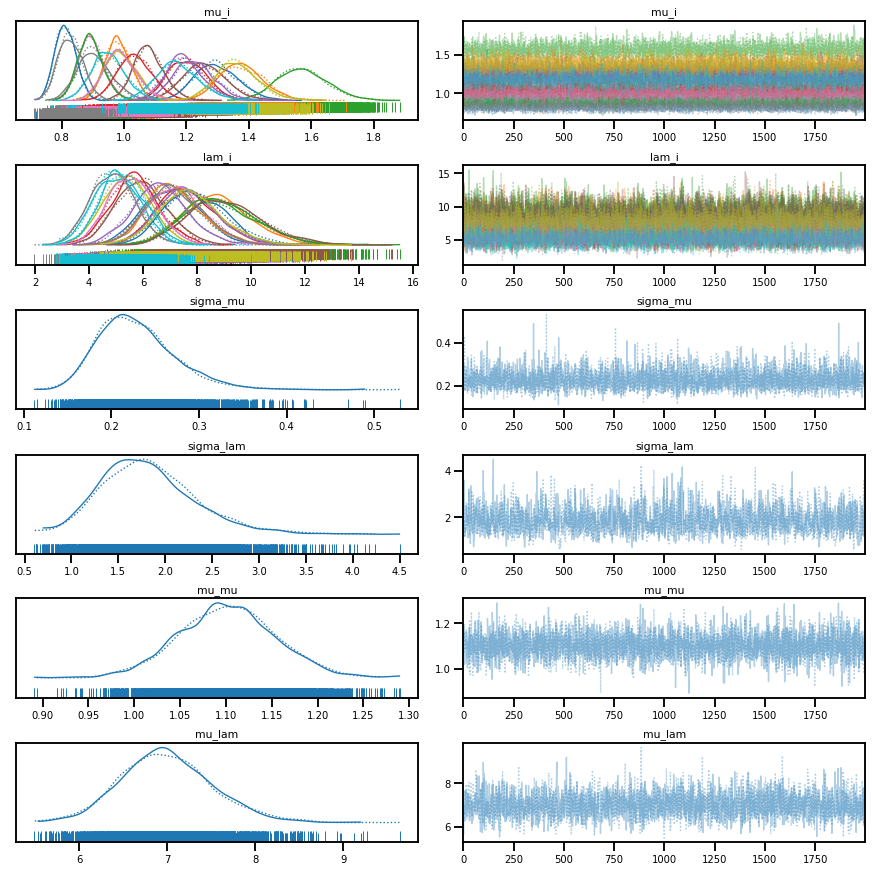

In [74]:
az.plot_trace(h_trace, rug=True)